In [1]:
import pygplates
from gprm.datasets import Reconstructions
import pygmt
import numpy as np
import pyshtools as pysh
from gprm import PointDistributionOnSphere


%load_ext autoreload
%autoreload 2

In [2]:
M2019 = Reconstructions.fetch_Muller2019()

In [3]:
topological_model = pygplates.TopologicalModel(
            M2019.dynamic_polygons,
            M2019.rotation_model,
            # Enable strain rate clamping to better control crustal stretching factors...
            default_resolve_topology_parameters=pygplates.ResolveTopologyParameters(enable_strain_rate_clamping=True))


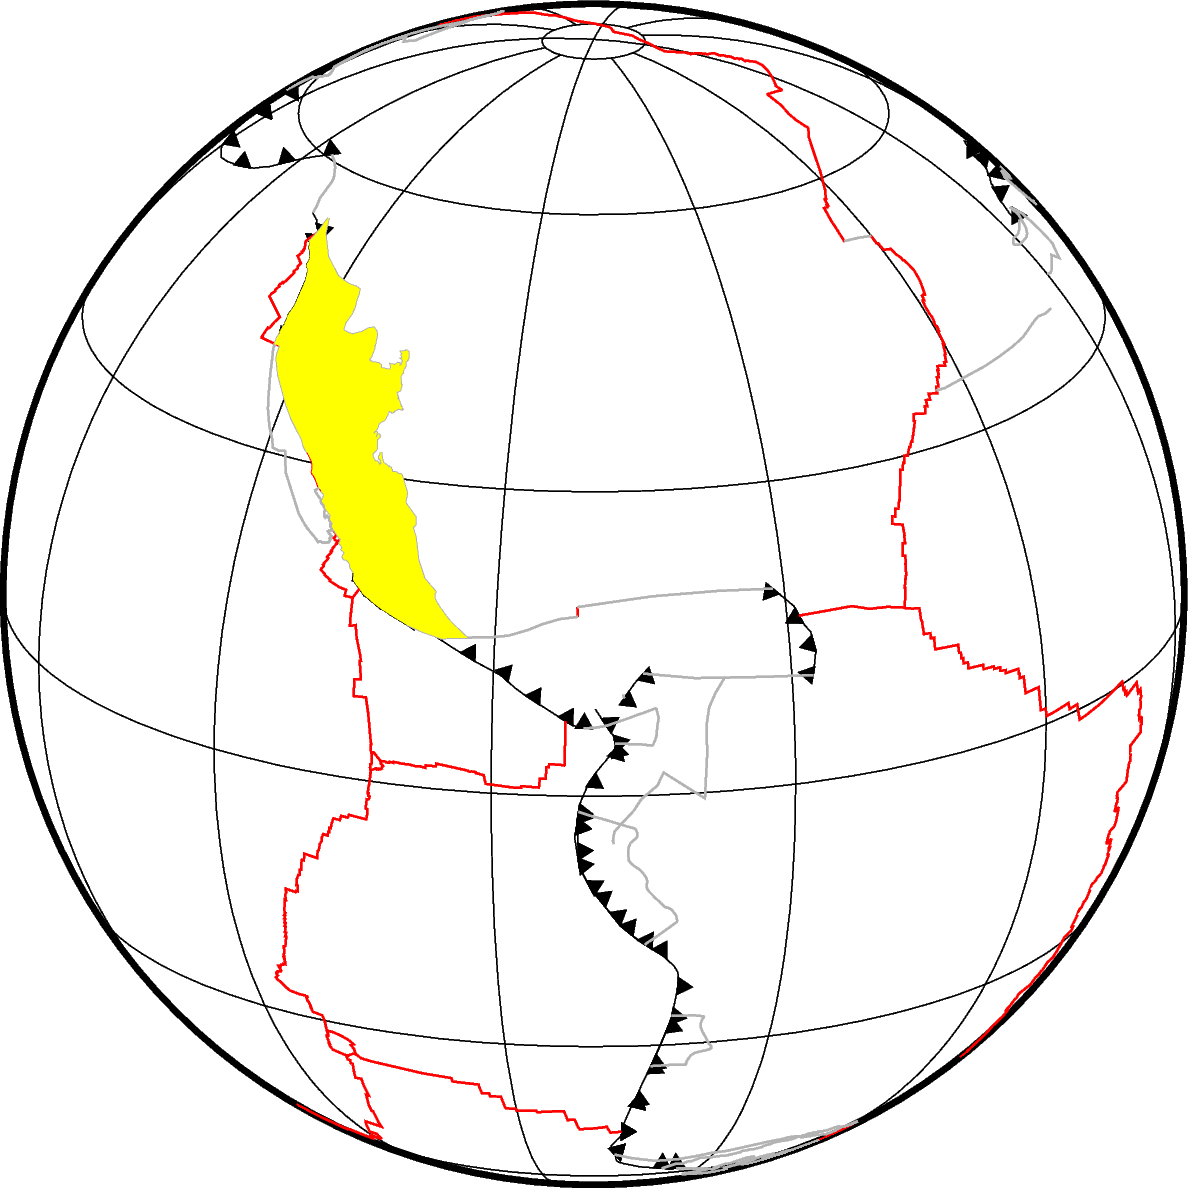

In [4]:
reconstruction_time = 0.

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)

fig = pygmt.Figure()
fig.basemap(region='d', projection='G-80/20/10c', frame='afg')
#reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)

for poly in reconstructed_plates.resolved_topologies:
    if poly.get_feature().get_name() == 'Deforming western interior NAM':
        geom = poly.get_resolved_geometry().to_lat_lon_array()
        #print(geom)
        #print('here')
        fig.plot(x=geom[:,1], y=geom[:,0], color='yellow')

fig.show(width=800)


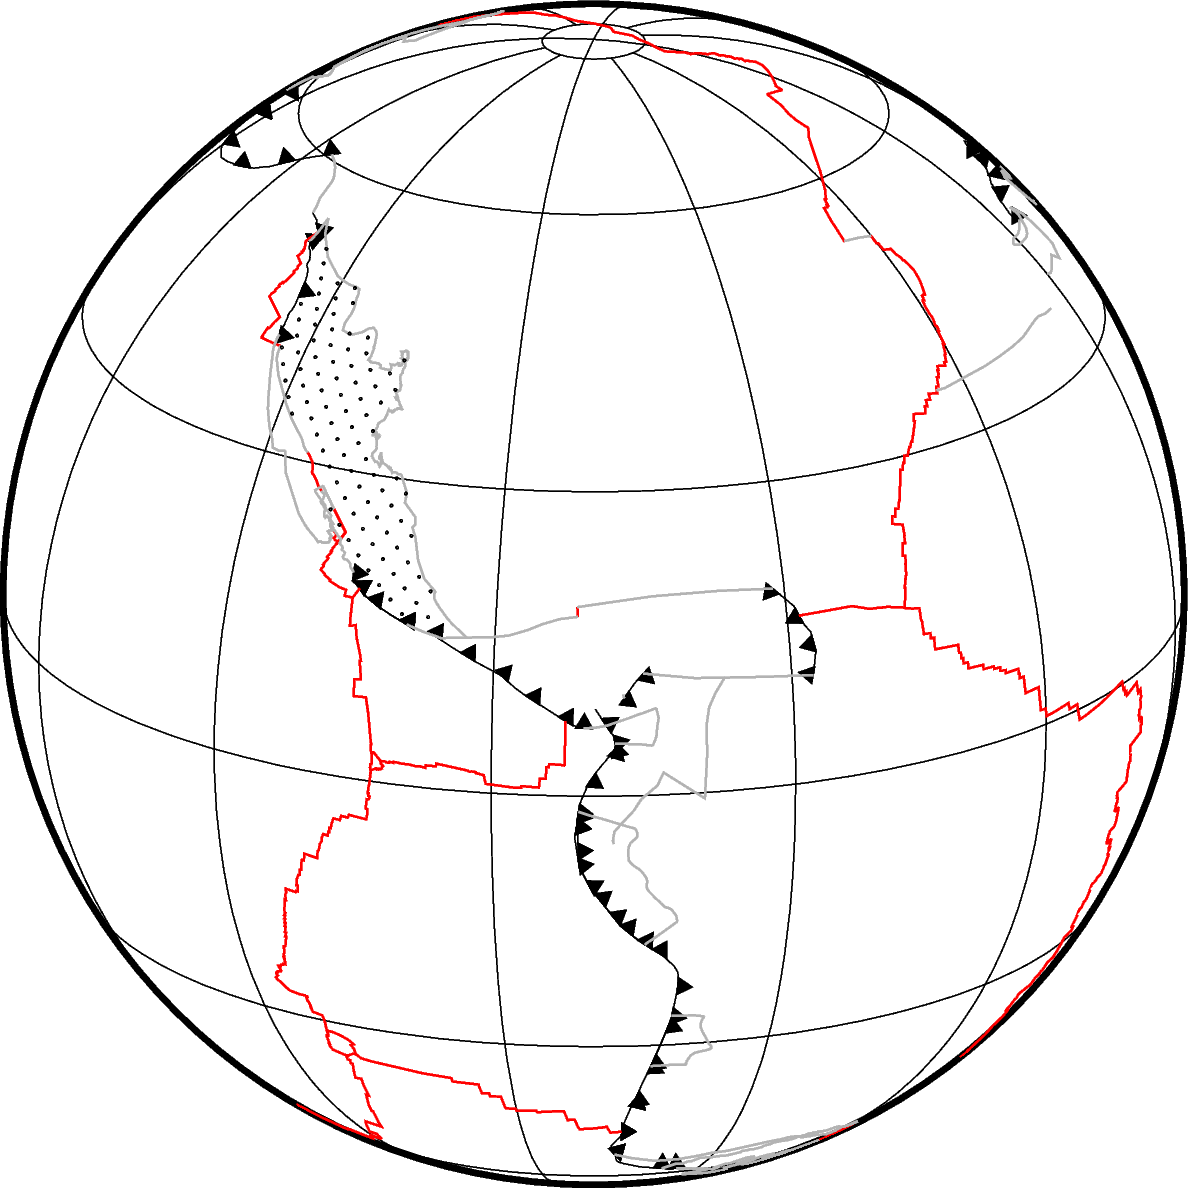

In [5]:
pts = PointDistributionOnSphere(distribution_type='healpix', N=32)

for poly in reconstructed_plates.resolved_topologies:
    if poly.get_feature().get_name() == 'Deforming western interior NAM':
        geom = poly.get_resolved_geometry()

pts_in_NAM = []
for pt in pts.multipoint.get_points():
    if geom.is_point_in_polygon(pt):
        pts_in_NAM.append(pt)
reconstructed_crustal_stretching_factors = [1.0] * len(pts_in_NAM)       
        
pts_to_plot = list(zip(*[point.to_lat_lon() for point in pts_in_NAM]))


fig = pygmt.Figure()
fig.basemap(region='d', projection='G-80/20/10c', frame='afg')
#reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)

fig.plot(x=pts_to_plot[1], y=pts_to_plot[0], style='c0.02c')

fig.show(width=800)


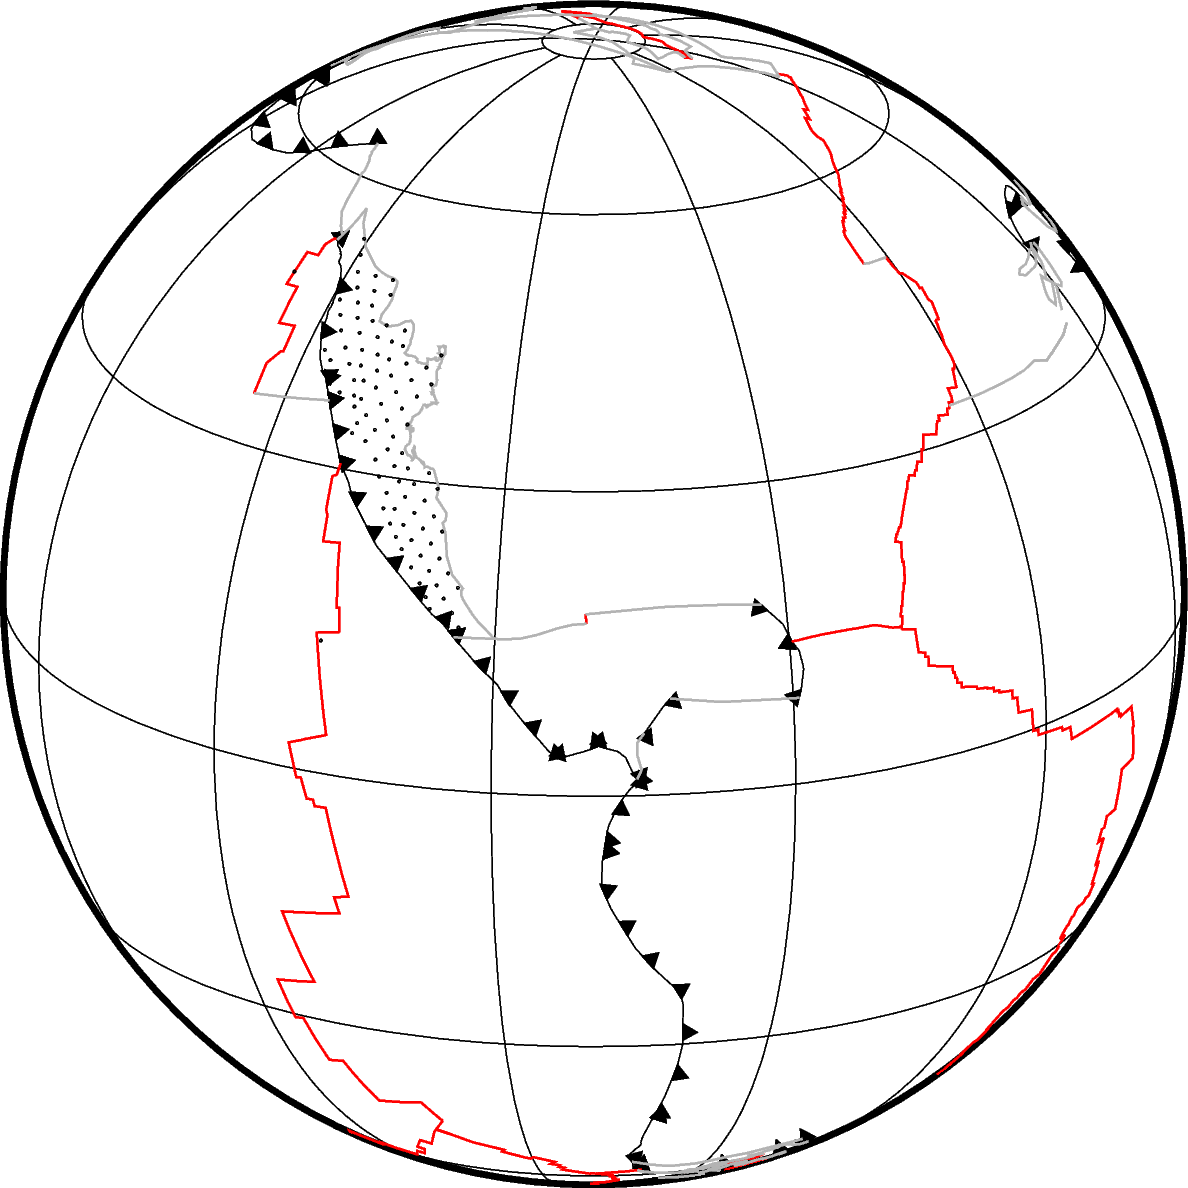

In [8]:
initial_time = 0.
final_time = 35.
reconstruction_time = 25.


time_spans = topological_model.reconstruct_geometry(
                pts_in_NAM,
                initial_time=initial_time,
                oldest_time=final_time,
                youngest_time=initial_time,
                # All our points are on continental crust so we keep them active through time (ie, never deactivate them)...
                deactivate_points=None)


reconstructed_points = time_spans.get_geometry_points(reconstruction_time, return_inactive_points=True)

def_pts = list(zip(*[reconstructed_point.to_lat_lon() for reconstructed_point in reconstructed_points]))

reconstructed_plates = M2019.plate_snapshot(reconstruction_time)

fig = pygmt.Figure()
fig.basemap(region='d', projection='G-80/20/10c', frame='afg')
#reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)

fig.plot(x=def_pts[1], y=def_pts[0], style='c0.02c')

fig.show(width=800)


In [9]:
circle_radius_degrees = 0.75

circle_list = []
for lon,lat in zip(pts_to_plot[1], pts_to_plot[0]):
    circle_list.append(pysh.utils.MakeCircleCoord(lat,lon,circle_radius_degrees))
    
circle_points = [(lat,lon) for lat,lon in circle_list[0]]


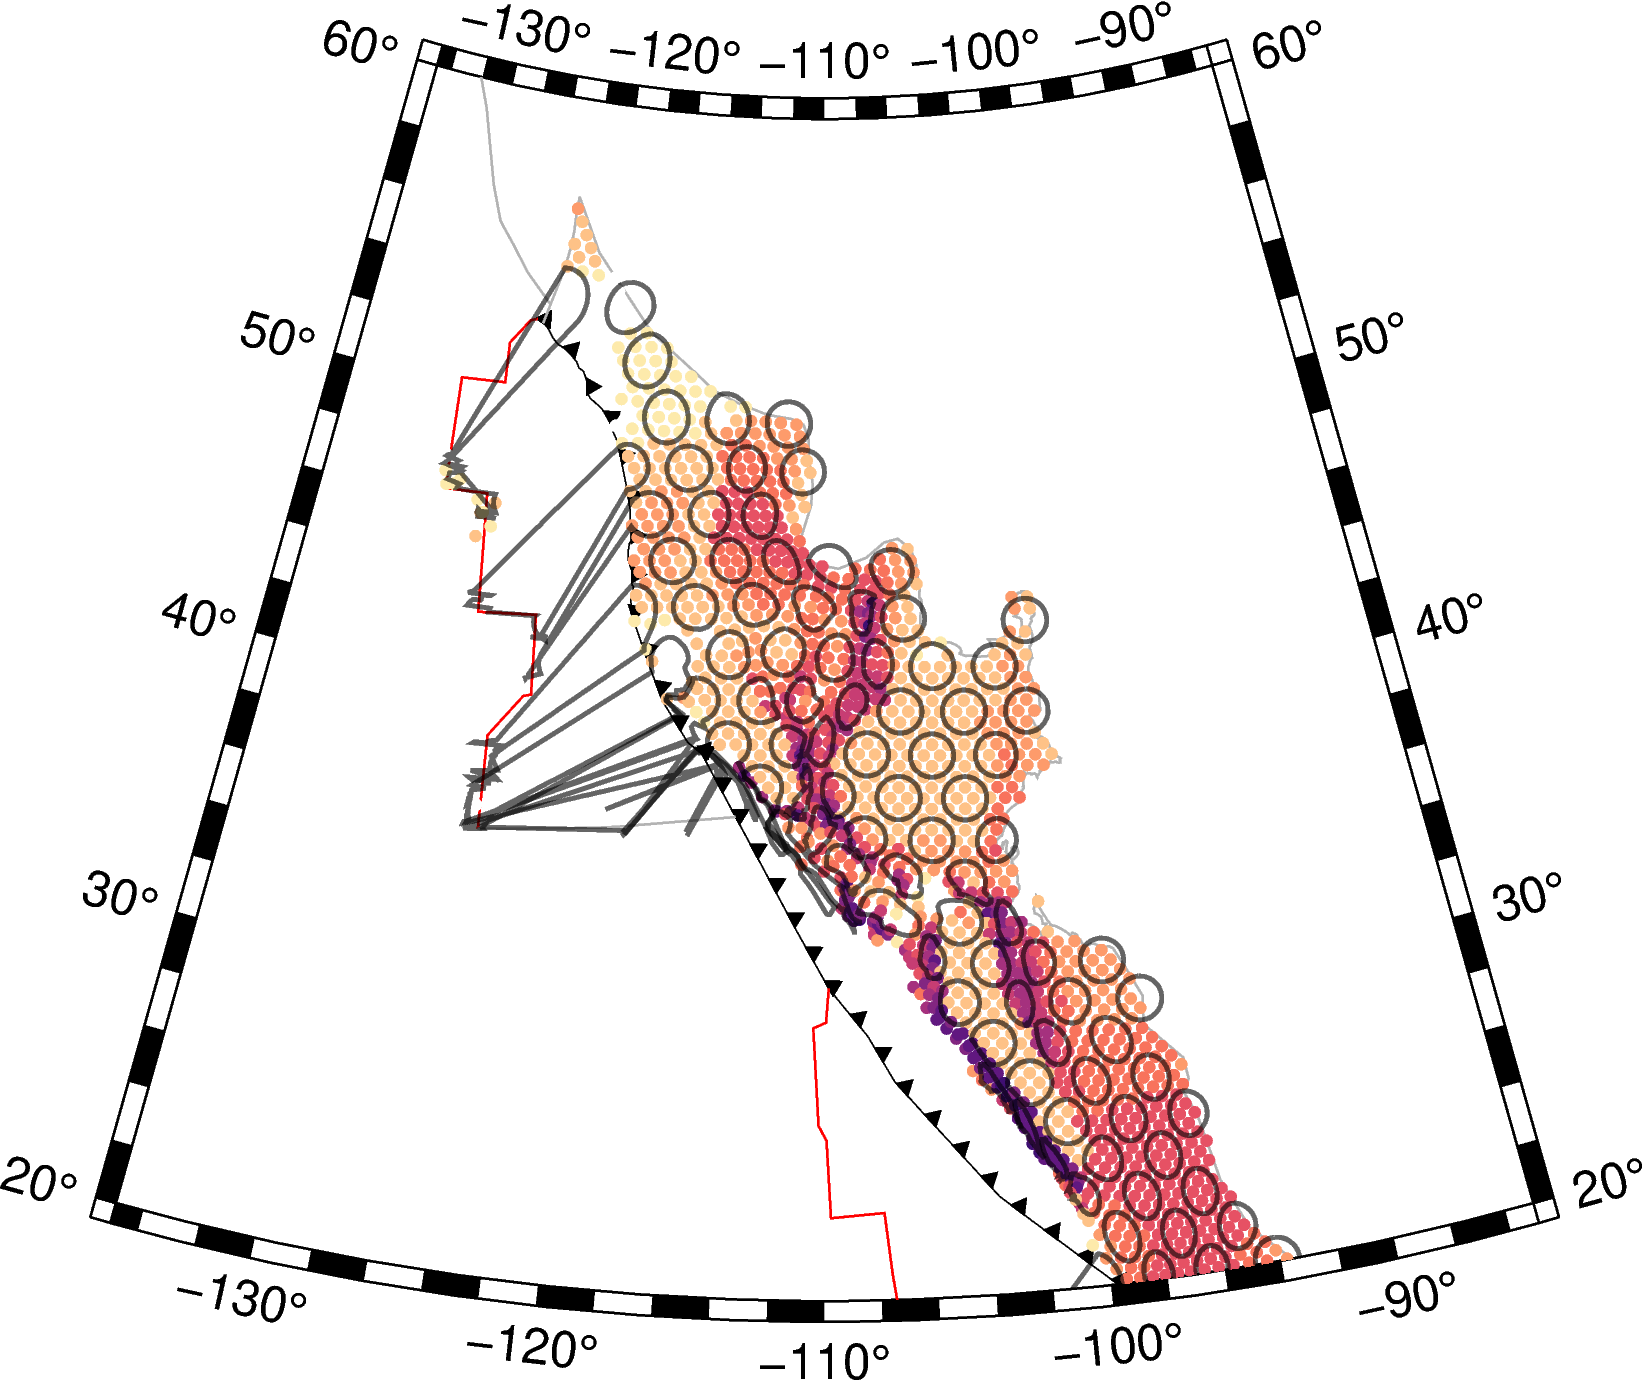

In [31]:
pts = PointDistributionOnSphere(distribution_type='healpix', N=128)
pts_in_NAM = []
for pt in pts.multipoint.get_points():
    if geom.is_point_in_polygon(pt):
        pts_in_NAM.append(pt)
reconstructed_crustal_stretching_factors = [1.0] * len(pts_in_NAM)  

time_spans = topological_model.reconstruct_geometry(
    pts_in_NAM,
    initial_time=initial_time,
    oldest_time=final_time,
    youngest_time=initial_time,
    initial_scalars={pygplates.ScalarType.gpml_crustal_stretching_factor : reconstructed_crustal_stretching_factors},
    # All our points are on continental crust so we keep them active through time (ie, never deactivate them)...
    deactivate_points=None)

reconstructed_points = time_spans.get_geometry_points(reconstruction_time, return_inactive_points=True)
crustal_stretching_factors = time_spans.get_scalar_values(reconstruction_time, 
                                                          return_inactive_points=True)[pygplates.ScalarType.gpml_crustal_stretching_factor]
def_pts = list(zip(*[reconstructed_point.to_lat_lon() for reconstructed_point in reconstructed_points]))



fig = pygmt.Figure()
fig.basemap(region=[-135, -85, 20, 60],
            projection="L-110/35/33/45/12c", 
            frame='af')
#reconstructed_continents.plot(fig, color='darkkhaki')
reconstructed_plates.plot_subduction_zones(fig)
reconstructed_plates.plot_mid_ocean_ridges(fig)
reconstructed_plates.plot_other_boundaries(fig)

pygmt.makecpt(cmap='magma', series=[0,1.2,0.1])
fig.plot(x=def_pts[1], y=def_pts[0], color=crustal_stretching_factors, style='c0.1c', cmap=True)

#'''
for circle in circle_list:
    circle_points = [(lat,lon) for lat,lon in circle]

    time_spans = topological_model.reconstruct_geometry(
                    circle_points,
                    initial_time=initial_time,
                    oldest_time=final_time,
                    youngest_time=initial_time,
                    # All our points are on continental crust so we keep them active through time (ie, never deactivate them)...
                    deactivate_points=None)
    
    reconstructed_circle_points = time_spans.get_geometry_points(reconstruction_time, return_inactive_points=True)
    
    def_pts = list(zip(*[reconstructed_circle_point.to_lat_lon() for reconstructed_circle_point in reconstructed_circle_points]))

    fig.plot(x=def_pts[1], y=def_pts[0], pen='1.0p,black', t=40) #, color='dodgerblue')
#'''
fig.show(width=800)


#TODO sample litho1